### To begin with, let's start with some basic imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline

For this post, I'm going to use a time-series from the <em>Huge Stock Market Dataset</em>. This is just a sample time-series used to further ground the concepts you read about. At the end of this post, you'll be able to apply these concepts to any other time-series you want to.

In [2]:
aus1 = pd.read_csv("a.us.txt",sep=',', index_col=0, parse_dates=True, squeeze=True) 

In [3]:
aus1.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1999-11-18,30.713,33.754,27.002,29.702,66277506,0
1999-11-19,28.986,29.027,26.872,27.257,16142920,0
1999-11-22,27.886,29.702,27.044,29.702,6970266,0
1999-11-23,28.688,29.446,27.002,27.002,6332082,0
1999-11-24,27.083,28.309,27.002,27.717,5132147,0


In [4]:
aus1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4521.000000,4521.000000,4521.000000,4521.000000,4.521000e+03,4521.0
mean,27.856296,28.270442,27.452486,27.871357,3.993503e+06,0.0
std,12.940880,13.176000,12.711735,12.944389,2.665730e+06,0.0
min,7.223100,7.513900,7.087800,7.323800,0.000000e+00,0.0
25%,19.117000,19.435000,18.780000,19.089000,2.407862e+06,0.0
50%,24.456000,24.809000,24.159000,24.490000,3.460621e+06,0.0
75%,36.502000,37.046000,35.877000,36.521000,4.849809e+06,0.0
max,105.300000,109.370000,97.881000,107.320000,6.627751e+07,0.0


In [5]:
aus1.index

DatetimeIndex(['1999-11-18', '1999-11-19', '1999-11-22', '1999-11-23',
               '1999-11-24', '1999-11-26', '1999-11-29', '1999-11-30',
               '1999-12-01', '1999-12-02',
               ...
               '2017-10-30', '2017-10-31', '2017-11-01', '2017-11-02',
               '2017-11-03', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10'],
              dtype='datetime64[ns]', name='Date', length=4521, freq=None)

### Before we use this time-series, we first need to resample it into a time-series wherein each observation differs by a month.

In [6]:
y1 = aus1['Open'].resample('MS').mean()
y2 = aus1['Close'].resample('MS').mean()
y1.index

DatetimeIndex(['1999-11-01', '1999-12-01', '2000-01-01', '2000-02-01',
               '2000-03-01', '2000-04-01', '2000-05-01', '2000-06-01',
               '2000-07-01', '2000-08-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', name='Date', length=217, freq='MS')

### So far, so good! Let's plot the time-series and see what it looks like!

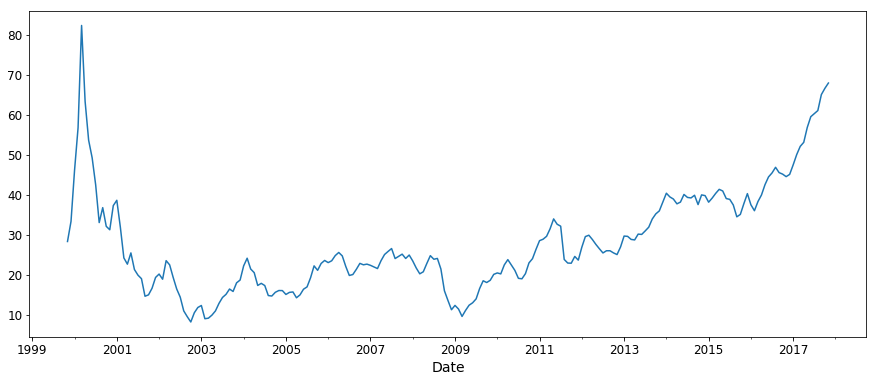

In [7]:
y1.plot(figsize=(15, 6))
plt.show()

### Now that we've seen what it looks like, let's try breaking it down into its components. Let's try extracting the trend, the seasonality and the residual of our time-series.

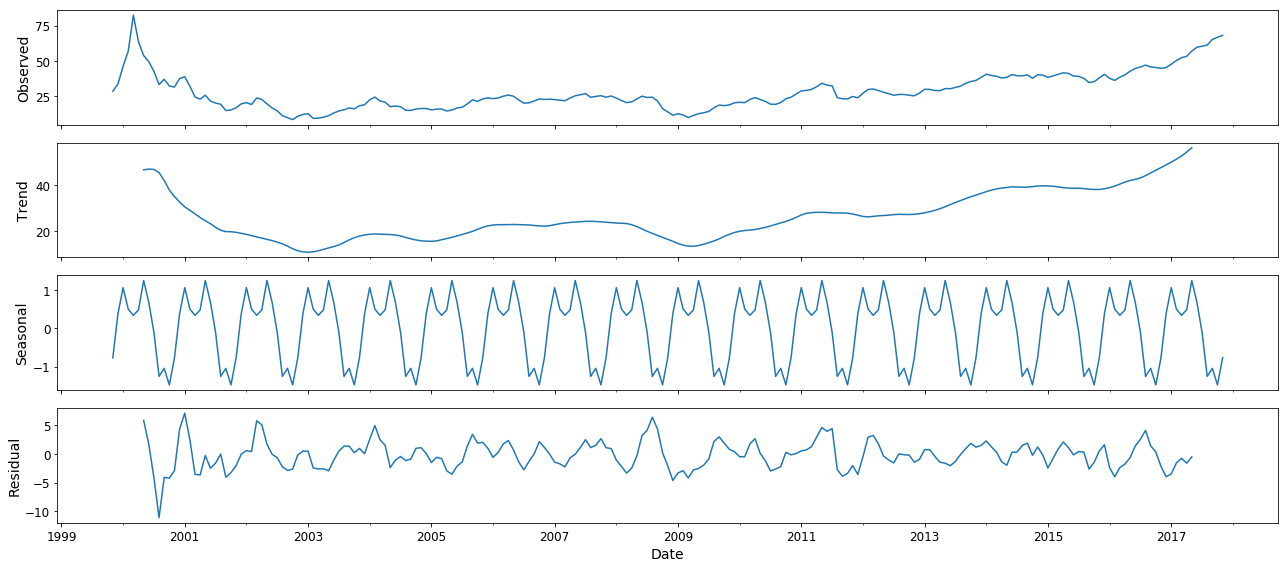

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y1, model='additive')
fig = decomposition.plot()
plt.show()

<em>Our inference from breaking the time-series down into components like seasonality and trend is that the given time-series is not stationary. Since the trend and seasonality of the time-series affect its values at different time-steps, this time-series is not stationary as its mean and variance keeps changing. Thus, we have to difference the time-series at least once to make it stationary.</em>

If you remember, we discussed the three parameters of the ARIMA Model. In order to determine these 3 parameters and finding the best combination of these 3 parameters in order to yield the best results, we'll use a combination of statistical tools and iteration(trying out different models to check which achieves the best results). 


<strong>Let's start by determining d. As we mentioned earlier, we'll keep differencing the time-series until it becomes stationary. Let's try differencing it once and use the Augmented Dickey Fuller Test to find if it is stationary or not.</strong>

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
y1_d = y1.diff()
y1_d = y1_d.dropna()
result = adfuller(y1_d)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.955284
p-value: 0.039287


<em>As we see that the p-value obtained is less than 0.05, we can reject the null hypothesis and say that the series is stationary. We can also see that the series has become more stationary from the plot above. Thus, obtaining a p-value of less than 0.05 using ADF is a good indicator that our time-series has become stationary.</em>

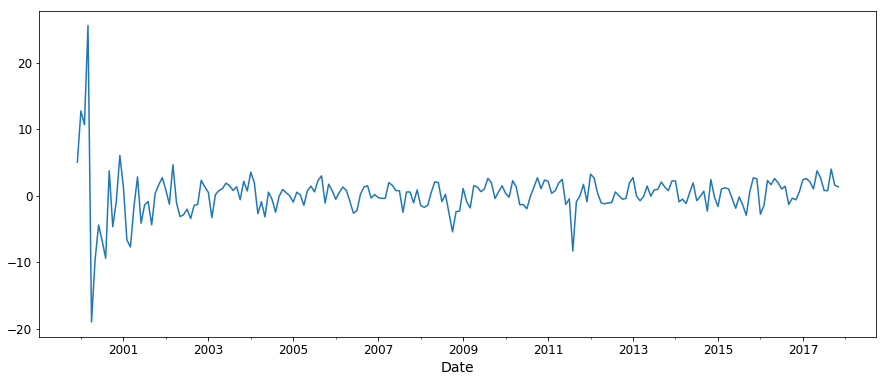

In [10]:
y1_d.plot(figsize=(15, 6))
plt.show()

<strong>In order to determine p, we need to first understand what an ACF plot is. Autocorrelation Function plot or ACF plot shows how correlated the variable is with its previous time-steps. For example, while predicting stock prices, the ACF plot tries to show how correlated the stock prices of March are to the stock prices of February, how likely are the stock prices in March to follow the behavior of stock prices in February. To better understand this, let's plot it.</strong>

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

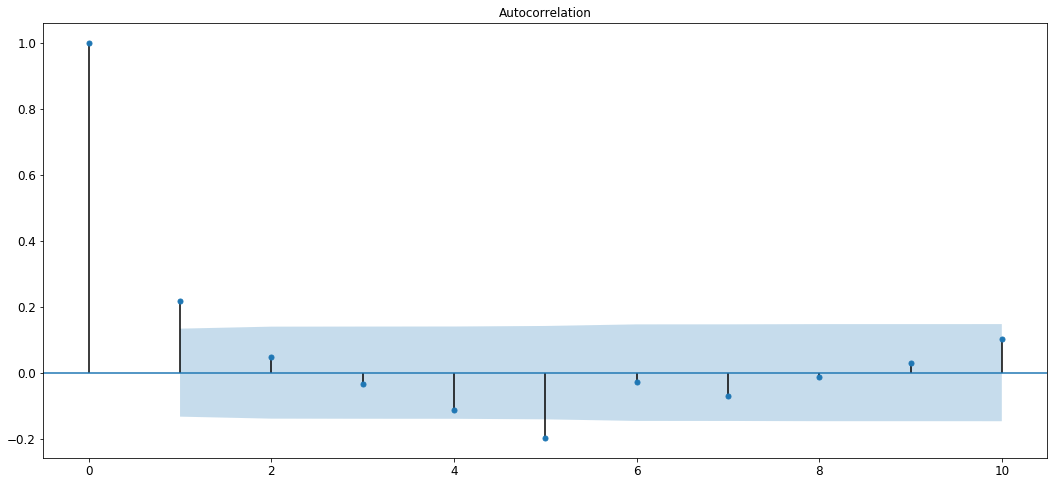

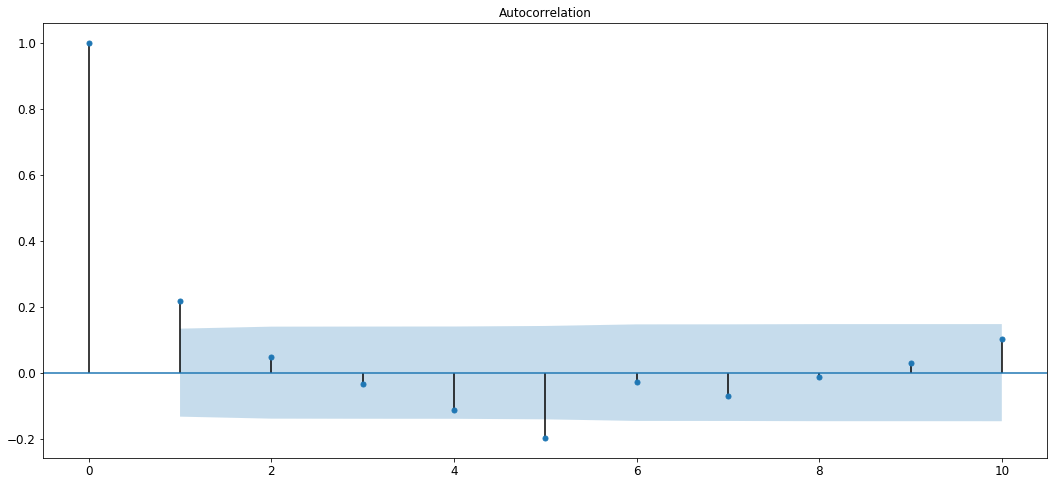

In [12]:
plot_acf(y1_d,lags=10)


<small>We can see that the auto-correlation is strong for the first 2 lags and then it decays and oscillates in the blue region.</small>

<em>Inferring from this, we can see that the first 1–2 lags show high correlation and values keep decreasing in the blue region.</em><br>
<strong>Thus, we can say that the value of p will lie in the range spanning from 1 to 2.</strong>
<hr>

<strong>Let's try determining q now. The process of determining q is very similar to the process of determining p. Instead of using ACF, we'll now use a PACF, or a Partial Autocorrelation Function. A PACF plot shows how correlated a variable is with itself at a previous time-step, ignoring all linear dependencies it has on time-steps that lie between the time-step against which correlation is to be found and the current time-step. Also called a conditional correlation fucntion, PACF aims to find the correlation between two time-steps independent of all other time-steps in between. Let's understand this better with a plot.</strong>

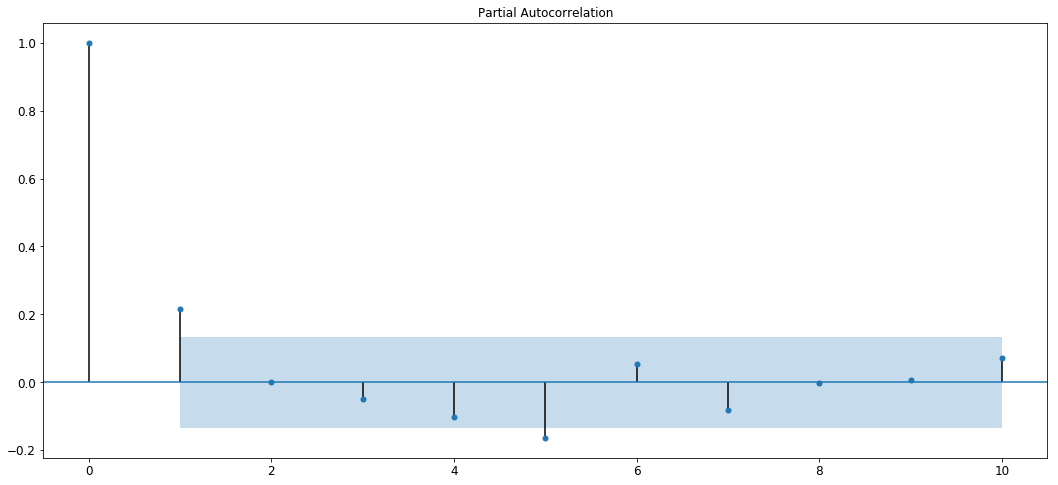

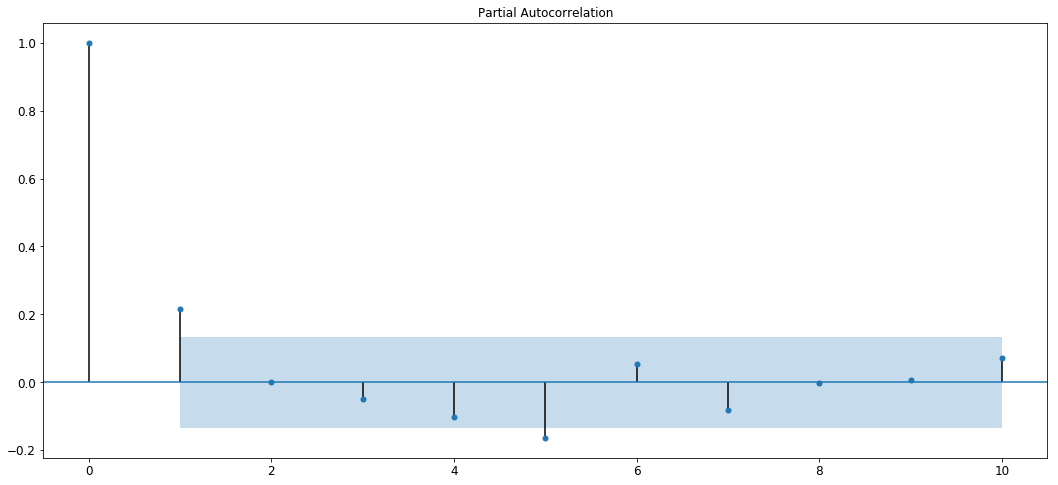

In [13]:
plot_pacf(y1_d,lags=10)

<em>From the plot we can see that the plot cuts off to zero at the second lag so we can estimate that the value of q will be lesser than 2.</em><br>
<strong>Thus, we can say that the value q shall lie in the range spanning from 0 to 1.</strong>
<hr>

### You've finally learnt the necessary building blocks required to create an ARIMA model in order to perform time-series forecasting! Let's jump right into it!

We divide our time-frame into a training and a testing set so that we can later gauge how well our model is performing. Training data is 70% of the original time-series data and testing data is 30% of the original time-series data.

In [14]:
size = int(len(y1) * 0.7)
train, test = y1[0:size], y1[size:len(y1)]
series = [y1 for y1 in train]
predictions = []

#### Alright, now let's start training the model! Let's try using values of (p,d,q) equal to (2,1,1) and see how the model performs!

Test error is 3.273019781729989


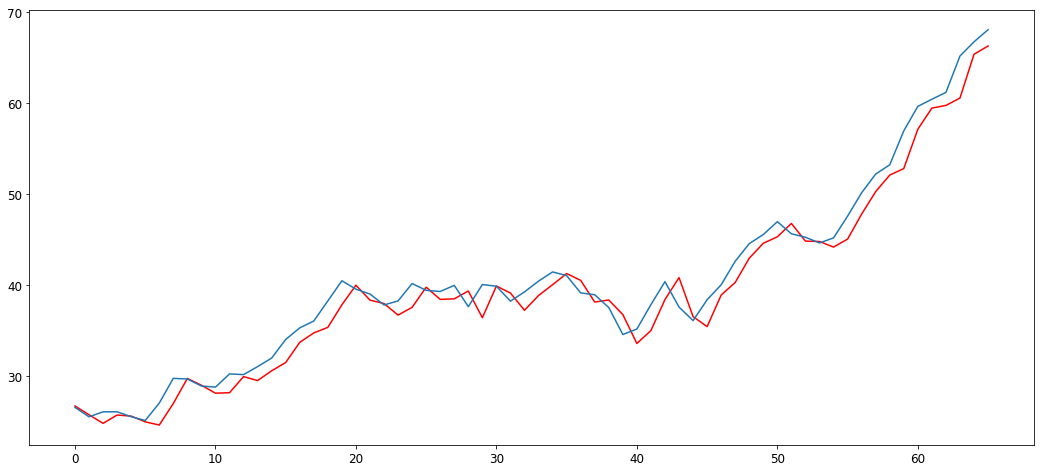

In [15]:
for y in range(len(test)):
    arima_model = ARIMA(series, order=(2,1,1))
    model_fit = arima_model.fit(disp=0)
    preds = model_fit.forecast()
    pred = preds[0]
    predictions.append(pred)
    actual_val = test[y]
    series.append(actual_val)
error = mean_squared_error(test, predictions)
print('Test error is {}'.format(error))
plt.plot(predictions,'r')
plt.plot(np.array(test))

<em>We can see that the model has learnt the nature and behavior of the time-series, and is performing pretty well on the test set!</em>

#### Let's try out new values of (p,d,q). Let's try out (1,1,1) this time and see if we obtain better results.

In [16]:
size = int(len(y1) * 0.7)
train, test = y1[0:size], y1[size:len(y1)]
series = [y1 for y1 in train]
predictions = []

Test error is 2.355571525013936


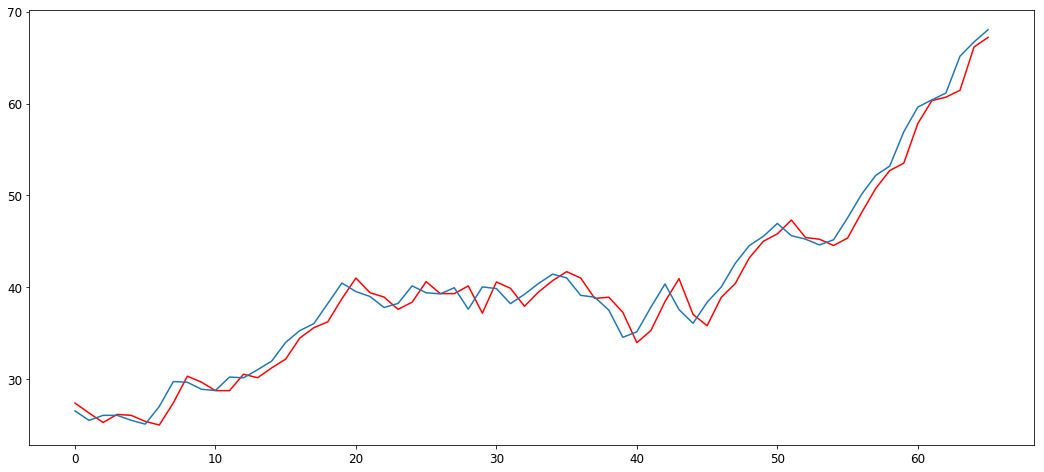

In [17]:
for y in range(len(test)):
    arima_model = ARIMA(series, order=(1,1,1)) 
    model_fit = arima_model.fit(disp=0)
    preds = model_fit.forecast()
    pred = preds[0]
    predictions.append(pred)
    actual_val = test[y]
    series.append(actual_val)
error = mean_squared_error(test, predictions)
print('Test error is {}'.format(error))
plt.plot(predictions,'r')
plt.plot(np.array(test))

### Great, we have obtained better results by changing the parameters of the model! By using the statistical methods above and by trying out different values, you can achieve great results on various different time-series.
<strong>I hope you're now acquainted with various concepts of Time-Series Forecasting and the ARIMA Model!</strong>